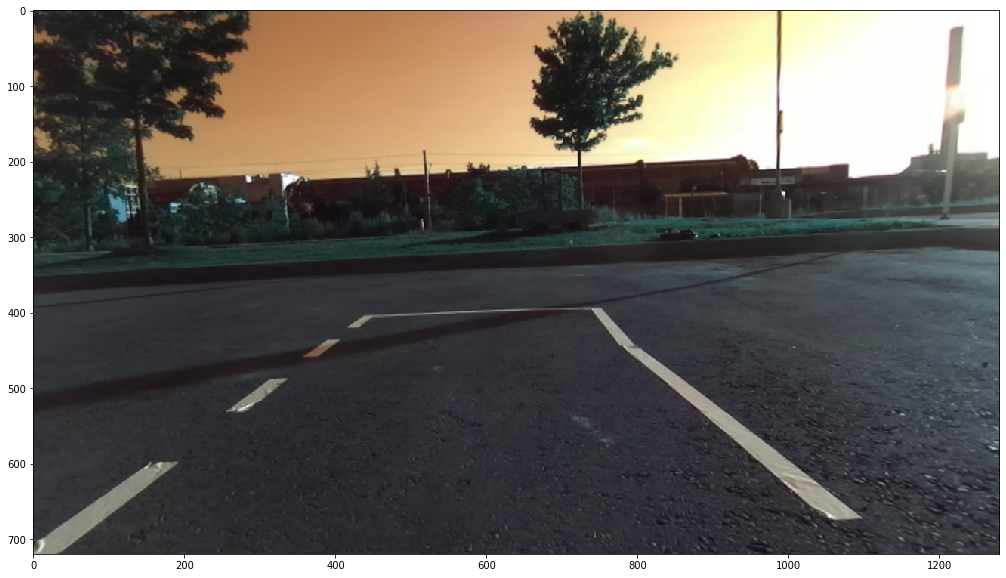

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timeit
plt.rcParams['figure.figsize'] = [18, 10]

img_bgr = cv2.imread("../images/lane_detection/urban_road/original.jpg")
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

plt.imshow(img_bgr)

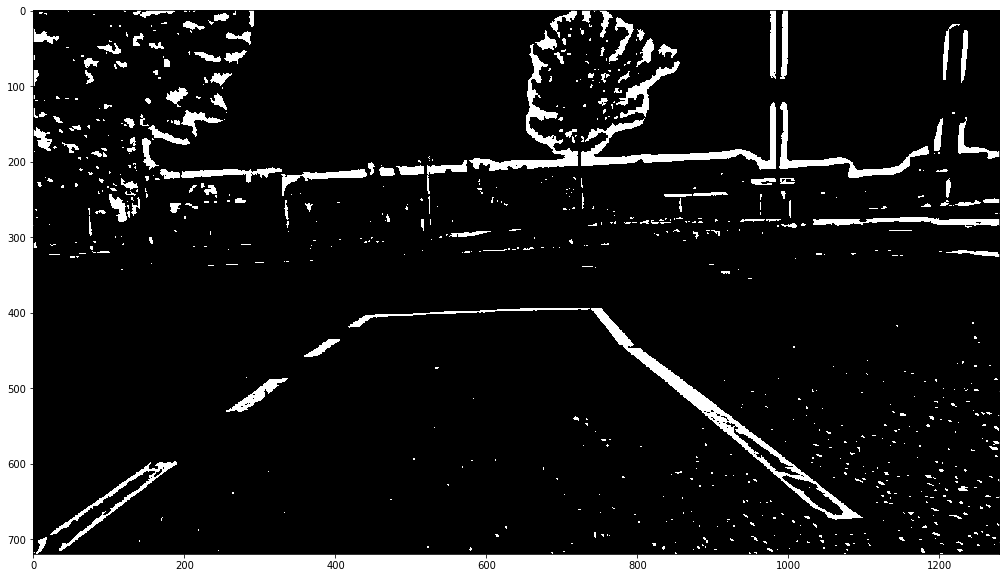

In [10]:
(channel_h, channel_s, channel_v) = cv2.split(img_hsv)
adaptive_thres = cv2.adaptiveThreshold(channel_v, 255, 
                                       cv2.ADAPTIVE_THRESH_MEAN_C, 
                                       cv2.THRESH_BINARY, 25, -20)

                               
plt.imshow(adaptive_thres, cmap='gray')

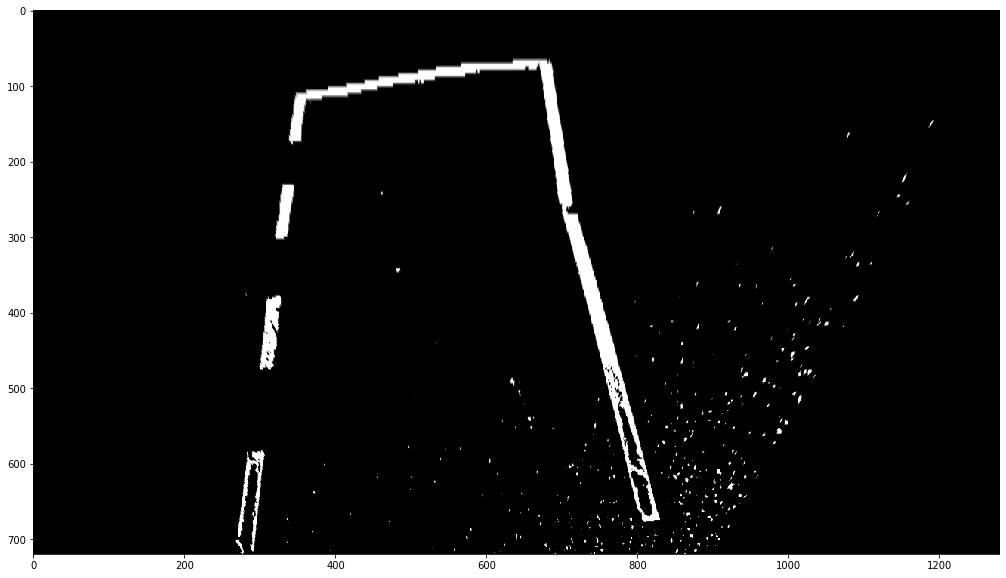

In [11]:
# Circuit race: (2m wide lanes)
# src = np.float32([[500,350], [750,350], [1280,550], [0,450]])

# Drag race: (1.5m wide lanes)
# src = np.float32([[400,350], [760,350], [1280,500], [0,500]])

# Urban race: (1m wide lanes)
src = np.float32([[420,380], [930,380], [1280,720], [50,720]])

dst = np.float32([[300, 0], [900,0], [900,720], [300,720]])

img_size = (adaptive_thres.shape[1], adaptive_thres.shape[0])
    
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(adaptive_thres, M, img_size)

plt.imshow(warped, cmap='gray')

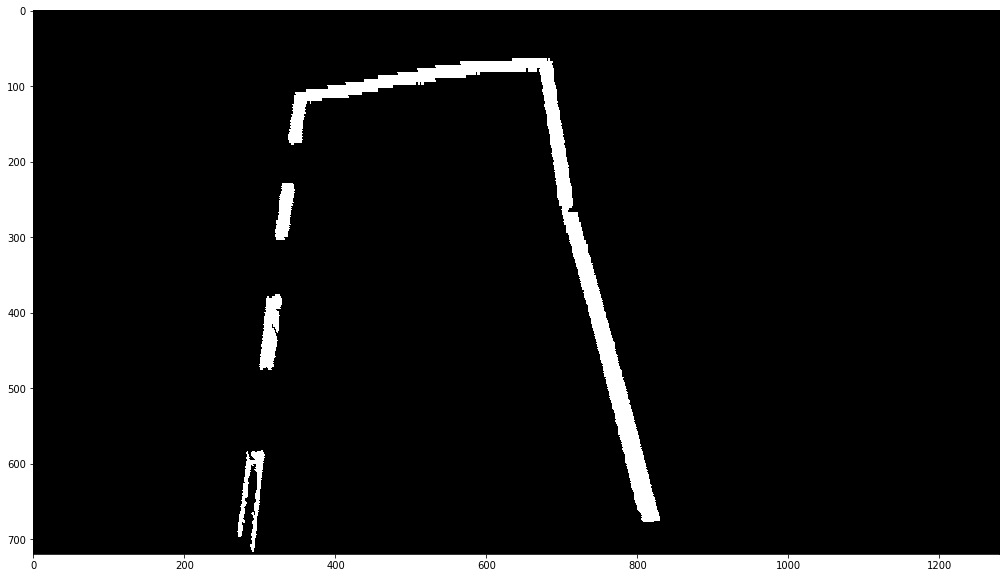

In [12]:
# Contours
blob_size = 200
filtered = np.zeros(warped.shape, np.uint8)

_, contours, _ = cv2.findContours(warped, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

for cnt in contours:
    if cv2.contourArea(cnt) >= blob_size: 
        cv2.drawContours(filtered, [cnt], -1, 255, -1)

plt.imshow(filtered, cmap='gray')


In [13]:
##################################### Horizontal Lane Removal Testing ############################################

0.021102685001096688


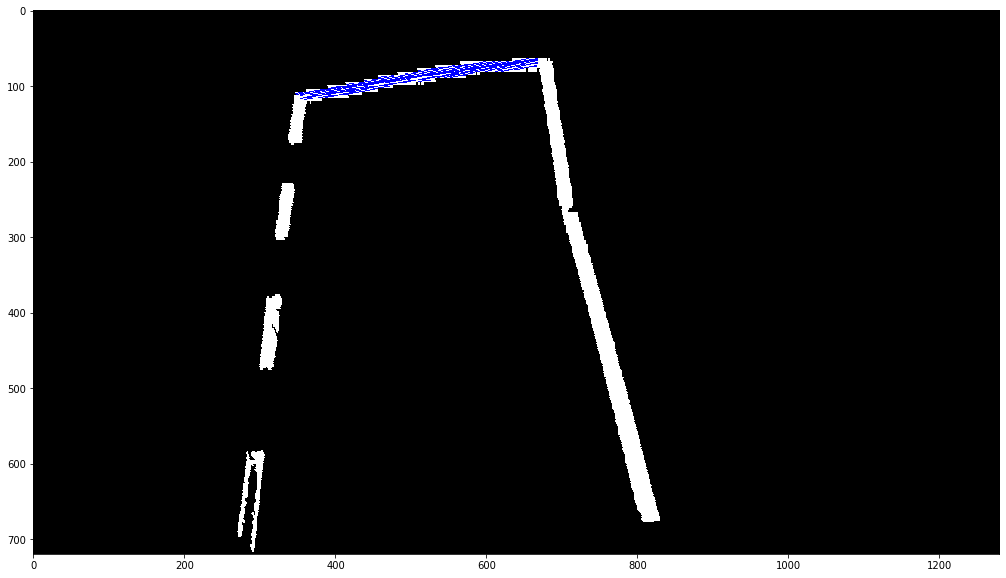

In [14]:
# Try using probobalistic hough lines
mask = np.zeros(filtered.shape)
display_img = filtered.copy()
display_img = cv2.cvtColor(display_img, cv2.COLOR_GRAY2BGR)
count = 0
minLineLength = 100
maxLineGap = 20

start_time = timeit.default_timer()
lines = cv2.HoughLinesP(filtered, 1, np.pi/180, 100, minLineLength, maxLineGap)
print(timeit.default_timer() - start_time)

for line in lines:
    x1,y1,x2,y2 = line[0]
    theta = np.arctan2(y2-y1, x2-x1)
    #print(theta*180/np.pi)
    #cv2.line(display_img,(x1,y1),(x2,y2),(0,0,255),2)
    if -30 <= theta*180/np.pi <= 30:
        cv2.line(mask,(x1,y1),(x2,y2),(255),15)
        cv2.line(display_img,(x1,y1),(x2,y2),(0, 0, 255),1)
        count+=1

plt.imshow(display_img)
#print(len(lines))
#print(count)

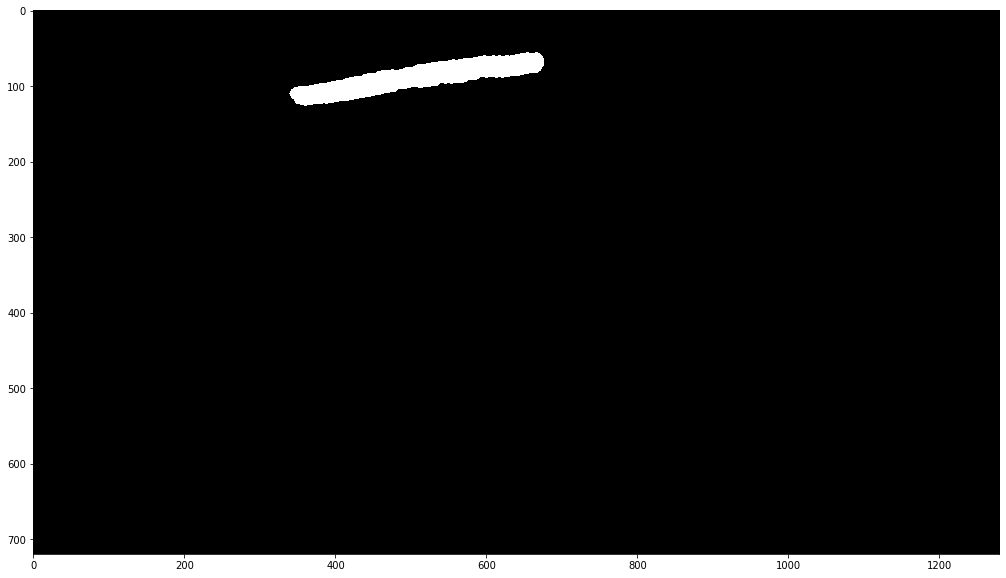

In [15]:
plt.imshow(mask, cmap='gray')

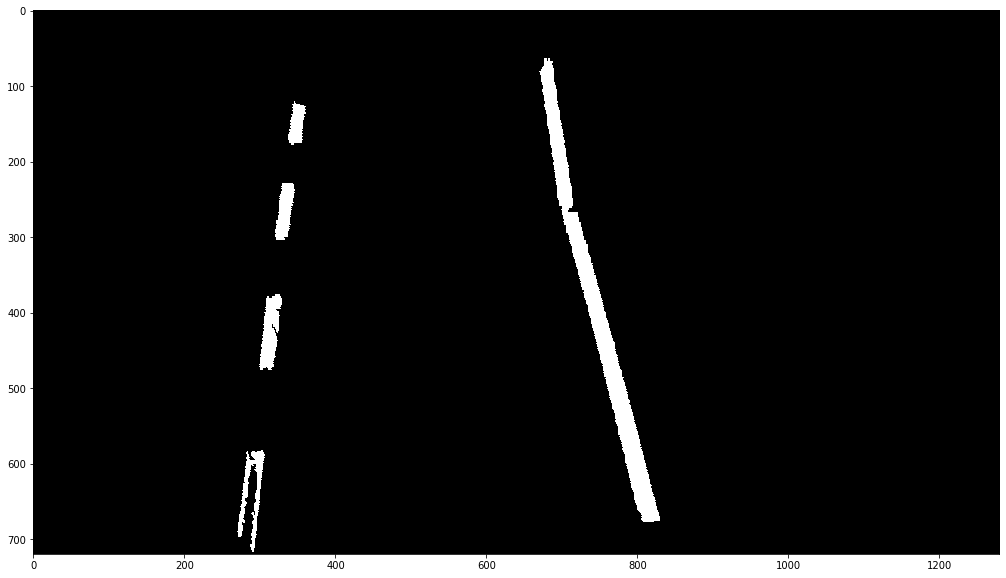

In [16]:
# Mask the lane image
vert_lanes = np.zeros(filtered.shape)
idx = (mask==0)
vert_lanes[idx] = filtered[idx]

plt.imshow(vert_lanes, cmap='gray')